In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ozguraslank_brain_stroke_ct_dataset_path = kagglehub.dataset_download('ozguraslank/brain-stroke-ct-dataset')

print('Data source import complete.')


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
from PIL import Image
import torchvision.models as models
from torchvision import transforms
from tqdm.notebook import tqdm
import random

In [ ]:
def set_seed(seed=42):
    """
    Setting random seeds for reproducibility across all libraries
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seeds set to {seed} for reproducibility")

set_seed(42)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Random seeds set to 42 for reproducibility


In [ ]:
dataset_path = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset"

# Analyze dataset
def analyze_dataset(root_dir):
    structure = {}
    for root, dirs, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)
        if rel_dir == '.':
            continue

        # Count files by extension
        file_counts = {}
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in file_counts:
                file_counts[ext] += 1
            else:
                file_counts[ext] = 1

        structure[rel_dir] = file_counts

    return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
    print(f"{dir_path}: {file_types}")

Dataset structure:
Ischemia: {}
Ischemia/DICOM: {'.dcm': 1130}
Ischemia/OVERLAY: {'.png': 1130}
Ischemia/PNG: {'.png': 1130}
Bleeding: {}
Bleeding/DICOM: {'.dcm': 1093}
Bleeding/OVERLAY: {'.png': 1093}
Bleeding/PNG: {'.png': 1093}
Normal: {}
Normal/DICOM: {'.dcm': 4427}
Normal/PNG: {'.png': 4427}
External_Test: {'.csv': 1}
External_Test/DICOM: {'.dcm': 200}
External_Test/OVERLAY: {'.png': 200}
External_Test/MASKS: {'.png': 200}
External_Test/PNG: {'.png': 200}


In [ ]:

def load_image_paths(dataset_path):
    """Load image paths with corresponding labels from the dataset structure"""
    image_paths = []
    labels = []

    # Dictionary to map class folders to numeric labels
    class_map = {
        'Normal': 0,
        'Bleeding': 1,
        'Ischemia': 2
    }

    # Iterate through each class folder
    for class_name, label in class_map.items():
        # Get all PNG images within this class
        png_path = os.path.join(dataset_path, class_name, 'PNG')

        if os.path.exists(png_path):
            png_files = glob.glob(os.path.join(png_path, '*.png'))

            # Add each image path with its label
            for img_path in png_files:
                image_paths.append(img_path)
                labels.append(label)
        else:
            print(f"Warning: Path {png_path} does not exist")

    return image_paths, labels

In [ ]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)
print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Class distribution
class_names = ['Normal', 'Bleeding', 'Ischemia']
label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"{class_names[i]}: {count} images")

Found 6650 images across 3 classes
Class distribution:
Normal: 4427 images
Bleeding: 1093 images
Ischemia: 1130 images


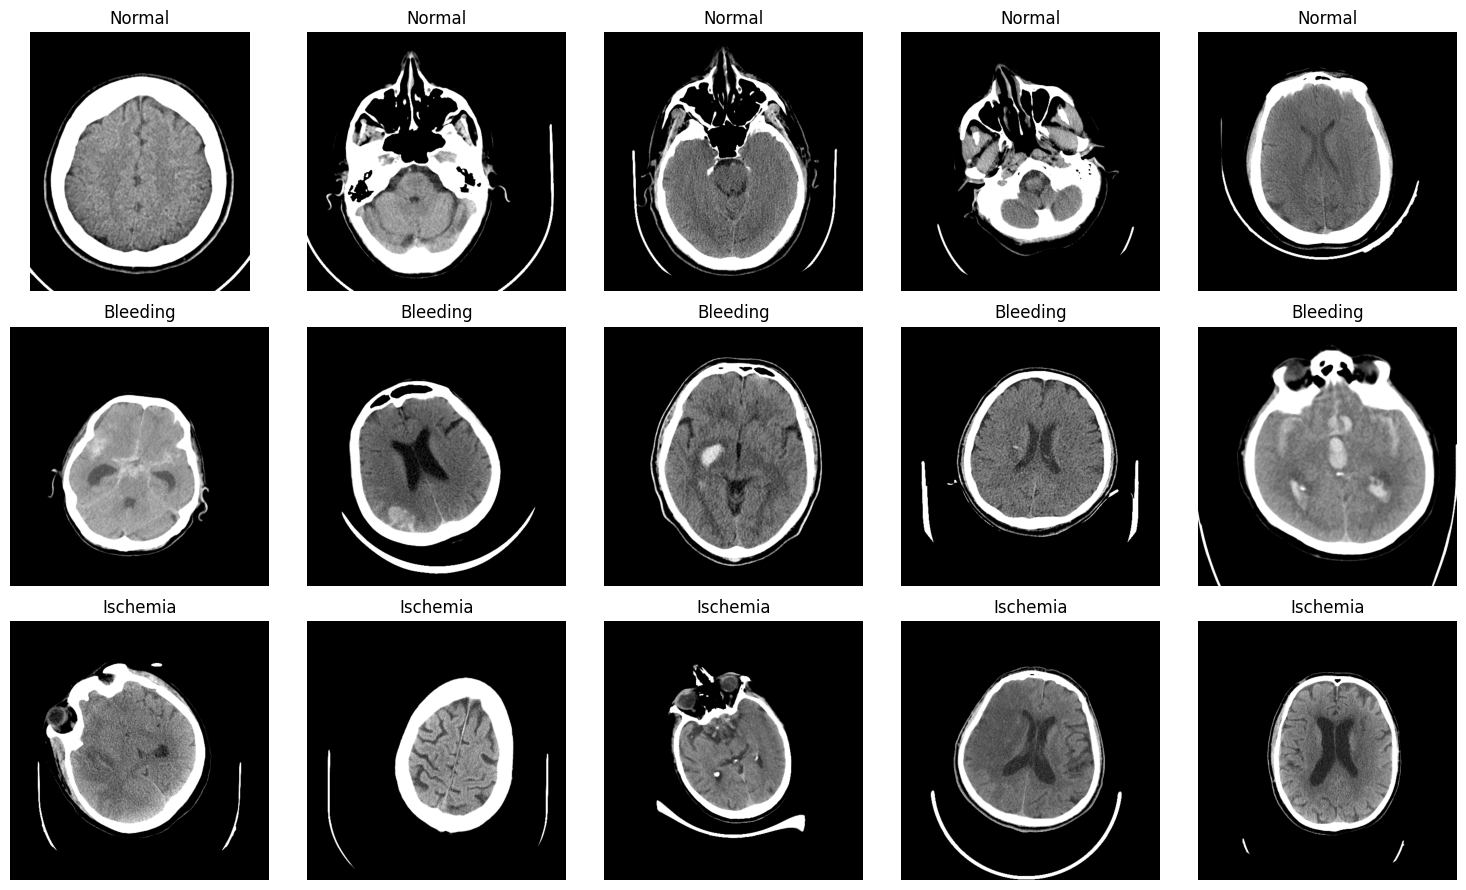

In [ ]:
def show_samples(image_paths, labels, n_samples=5):

    indices = {}
    for i in range(3):  
        class_indices = [idx for idx, label in enumerate(labels) if label == i]
        if len(class_indices) >= n_samples:
            indices[i] = np.random.choice(class_indices, n_samples, replace=False)
        else:
            indices[i] = class_indices

    # Create figure
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))

    for i in range(3): 
        for j in range(min(n_samples, len(indices[i]))):  # For each sample
            idx = indices[i][j]
            img = Image.open(image_paths[idx])
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_names[i])
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


show_samples(image_paths, labels)

In [ ]:

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 5320 images
Validation set: 1330 images


In [ ]:
# Create a custom dataset class for brain CT images
class BrainCTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

        # Get label
        label = self.labels[idx]

        return image, label

In [ ]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create datasets
train_dataset = BrainCTDataset(train_paths, train_labels, transform=transform_train)
val_dataset = BrainCTDataset(val_paths, val_labels, transform=transform_val)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check a batch of data
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ENSNET(nn.Module):
    def __init__(self, num_classes=3):
        super(ENSNET, self).__init__()
        # Load pre-trained models
        self.resnet = models.resnet18(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Load features
        resnet_features = self.resnet.fc.in_features
        densenet_features = self.densenet.classifier.in_features
        efficientnet_features = self.efficientnet.classifier[1].in_features  

        self.resnet.fc = nn.Identity()
        self.densenet.classifier = nn.Identity()
        self.efficientnet.classifier = nn.Identity()

        # Combine features
        total_features = resnet_features + densenet_features + efficientnet_features

        # Final classification layer
        self.classifier = nn.Linear(total_features, num_classes)

    def forward(self, x):
        # Forward through each model
        r = self.resnet(x)
        d = self.densenet(x)
        e = self.efficientnet(x)
        # Concatenate features
        features = torch.cat([r, d, e], dim=1)
        out = self.classifier(features)
        return out


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize ENSNET
model = ENSNET(num_classes=3)
model = model.to(device)

# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validating"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store predictions and targets for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_preds, all_targets


In [ ]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Set training parameters
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Start the training
print("Starting model training...")

Using device: cuda
Starting model training...



Epoch 1/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.5840, Train Acc: 0.7784
Val Loss: 1.0551, Val Acc: 0.7564
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      1.00      0.85       885
    Bleeding       0.98      0.56      0.72       219
    Ischemia       0.00      0.00      0.00       226

    accuracy                           0.76      1330
   macro avg       0.57      0.52      0.52      1330
weighted avg       0.65      0.76      0.68      1330



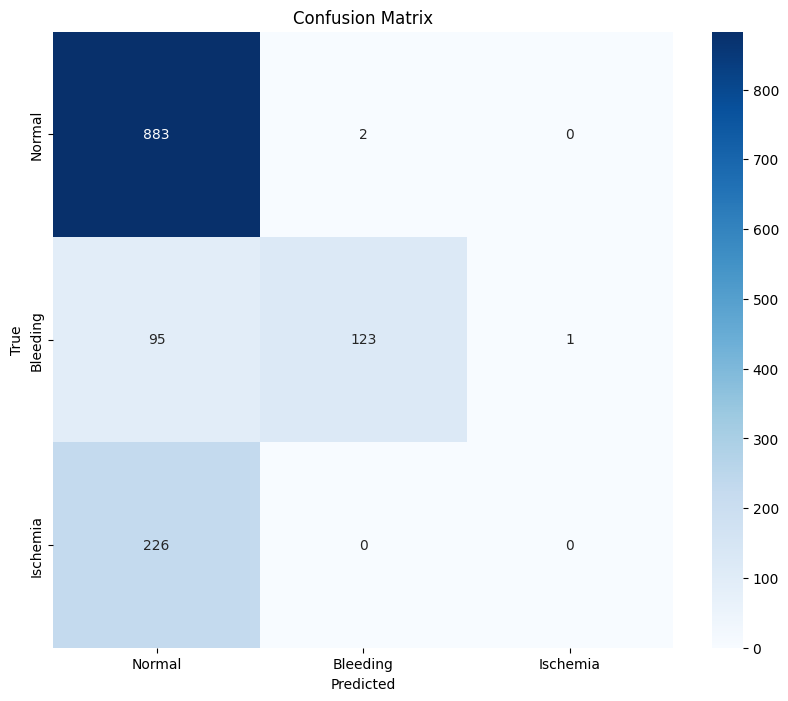


Epoch 2/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3899, Train Acc: 0.8622
Val Loss: 0.2493, Val Acc: 0.9165
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       885
    Bleeding       0.92      0.89      0.90       219
    Ischemia       0.83      0.77      0.80       226

    accuracy                           0.92      1330
   macro avg       0.89      0.87      0.88      1330
weighted avg       0.92      0.92      0.92      1330



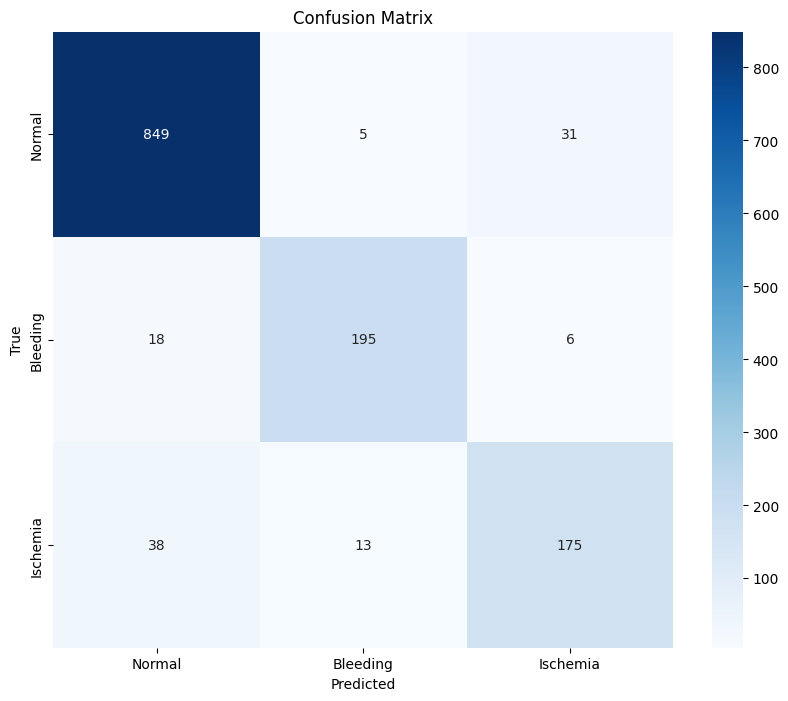


Epoch 3/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3095, Train Acc: 0.8944
Val Loss: 0.2835, Val Acc: 0.9105

Epoch 4/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2330, Train Acc: 0.9194
Val Loss: 0.2050, Val Acc: 0.9346
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       885
    Bleeding       0.98      0.83      0.90       219
    Ischemia       0.80      0.91      0.85       226

    accuracy                           0.93      1330
   macro avg       0.91      0.90      0.90      1330
weighted avg       0.94      0.93      0.94      1330



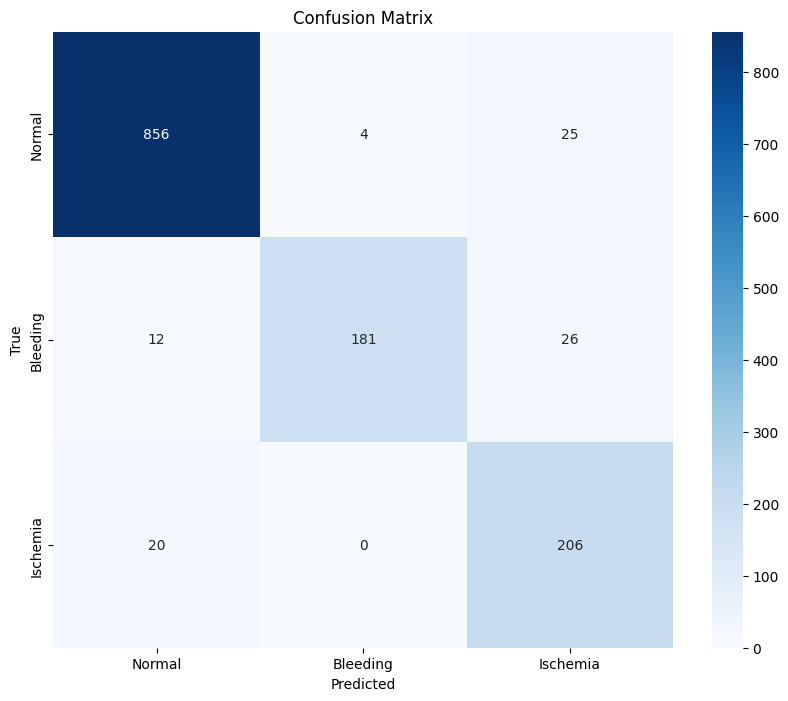


Epoch 5/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2352, Train Acc: 0.9188
Val Loss: 0.1924, Val Acc: 0.9248

Epoch 6/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1910, Train Acc: 0.9316
Val Loss: 0.1858, Val Acc: 0.9451
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       885
    Bleeding       0.99      0.88      0.93       219
    Ischemia       0.86      0.89      0.88       226

    accuracy                           0.95      1330
   macro avg       0.94      0.92      0.92      1330
weighted avg       0.95      0.95      0.95      1330



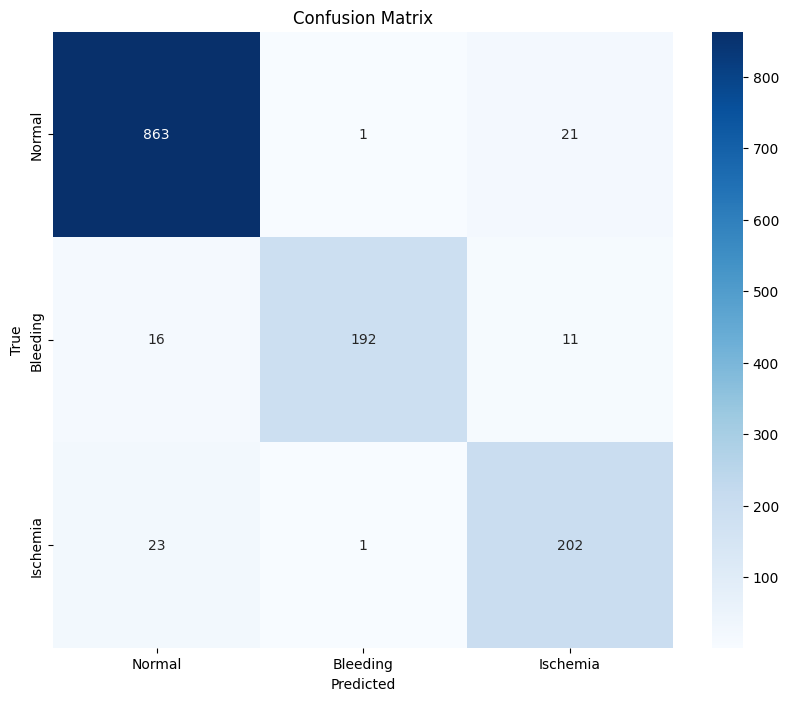


Epoch 7/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1511, Train Acc: 0.9466
Val Loss: 0.2909, Val Acc: 0.9203

Epoch 8/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1284, Train Acc: 0.9555
Val Loss: 0.2655, Val Acc: 0.9346

Epoch 9/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1339, Train Acc: 0.9528
Val Loss: 0.2854, Val Acc: 0.9068

Epoch 10/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1164, Train Acc: 0.9600
Val Loss: 0.2449, Val Acc: 0.9571
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97       885
    Bleeding       1.00      0.89      0.94       219
    Ischemia       0.95      0.88      0.91       226

    accuracy                           0.96      1330
   macro avg       0.97      0.92      0.94      1330
weighted avg       0.96      0.96      0.96      1330



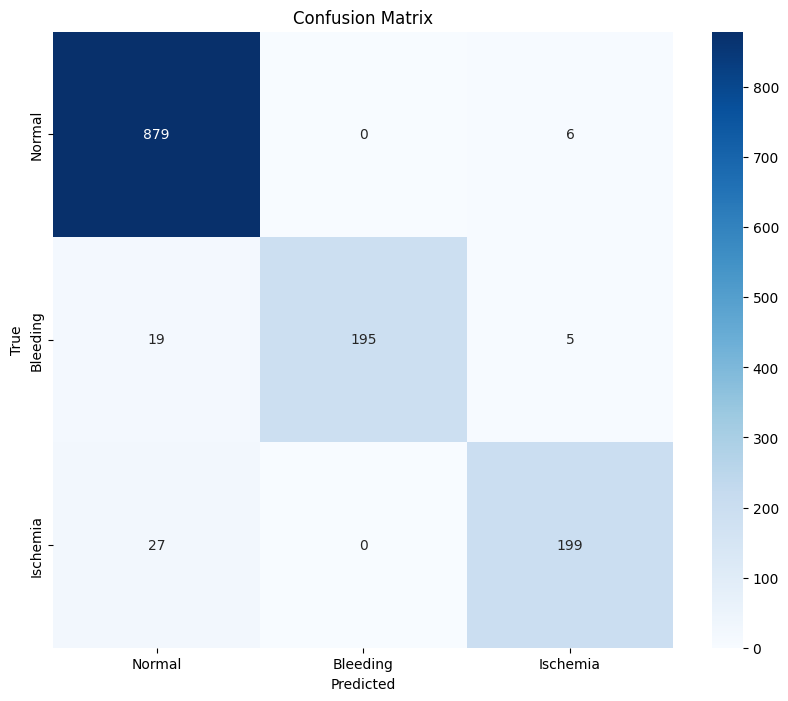


Epoch 11/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0913, Train Acc: 0.9699
Val Loss: 0.4724, Val Acc: 0.9383

Epoch 12/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1085, Train Acc: 0.9618
Val Loss: 0.2912, Val Acc: 0.9368

Epoch 13/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0745, Train Acc: 0.9752
Val Loss: 0.1463, Val Acc: 0.9511

Epoch 14/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0854, Train Acc: 0.9703
Val Loss: 0.2217, Val Acc: 0.9459

Epoch 15/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0819, Train Acc: 0.9703
Val Loss: 0.2296, Val Acc: 0.9534

Epoch 16/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0719, Train Acc: 0.9761
Val Loss: 0.2723, Val Acc: 0.9323

Epoch 17/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0301, Train Acc: 0.9895
Val Loss: 0.1295, Val Acc: 0.9692
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       885
    Bleeding       0.96      0.95      0.95       219
    Ischemia       0.94      0.91      0.93       226

    accuracy                           0.97      1330
   macro avg       0.96      0.95      0.96      1330
weighted avg       0.97      0.97      0.97      1330



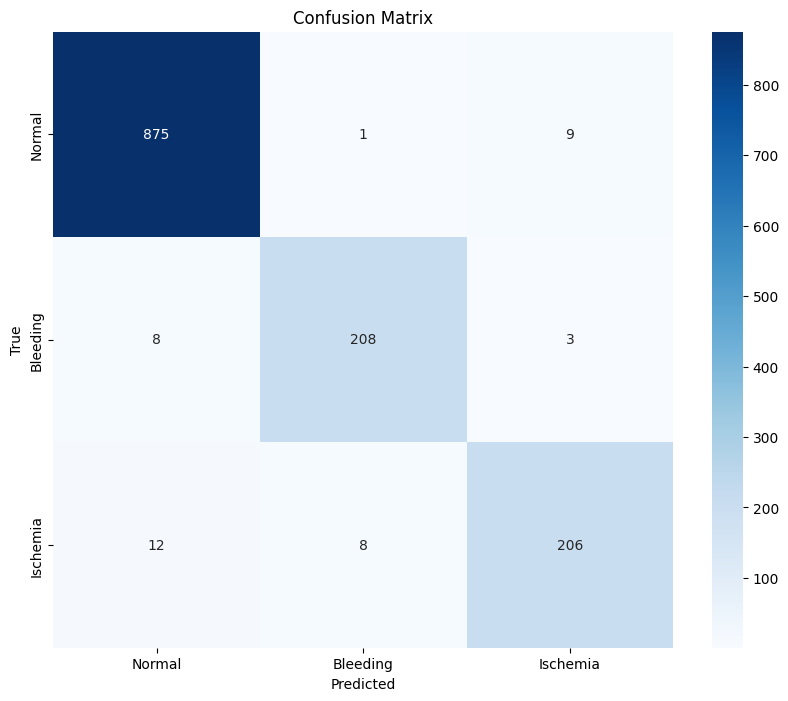


Epoch 18/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0287, Train Acc: 0.9921
Val Loss: 0.1090, Val Acc: 0.9684

Epoch 19/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0221, Train Acc: 0.9923
Val Loss: 0.3635, Val Acc: 0.9677

Epoch 20/20


Training:   0%|          | 0/333 [00:00<?, ?it/s]

Validating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0169, Train Acc: 0.9938
Val Loss: 0.1535, Val Acc: 0.9654


In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, all_preds, all_targets = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_acc)

    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_brain_ct_model.pth")
        print("Saved new best model!")

        # Detailed metrics for best model
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

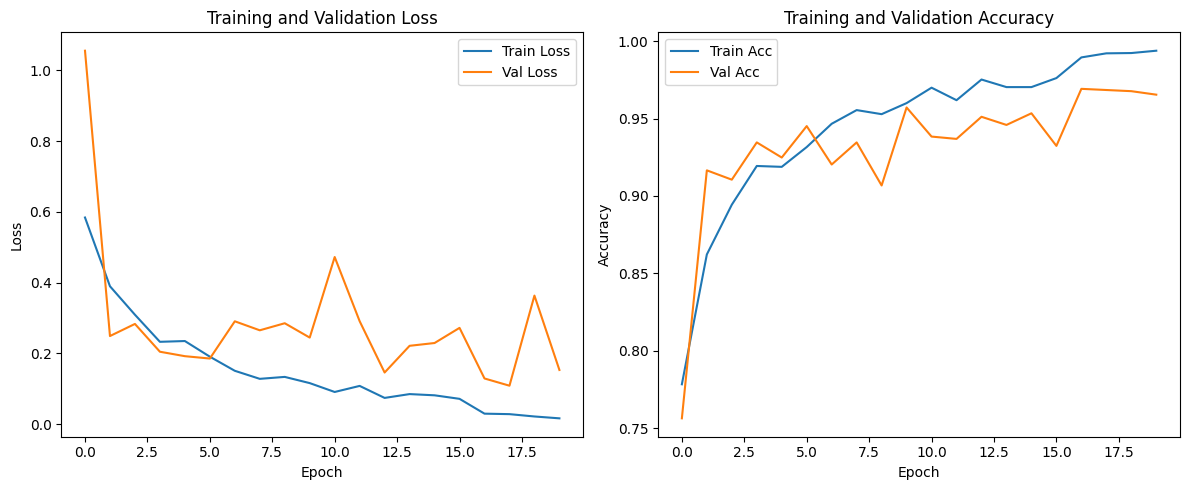

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Validating:   0%|          | 0/84 [00:00<?, ?it/s]


Final Validation Accuracy: 0.9692

Final Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       885
    Bleeding       0.96      0.95      0.95       219
    Ischemia       0.94      0.91      0.93       226

    accuracy                           0.97      1330
   macro avg       0.96      0.95      0.96      1330
weighted avg       0.97      0.97      0.97      1330



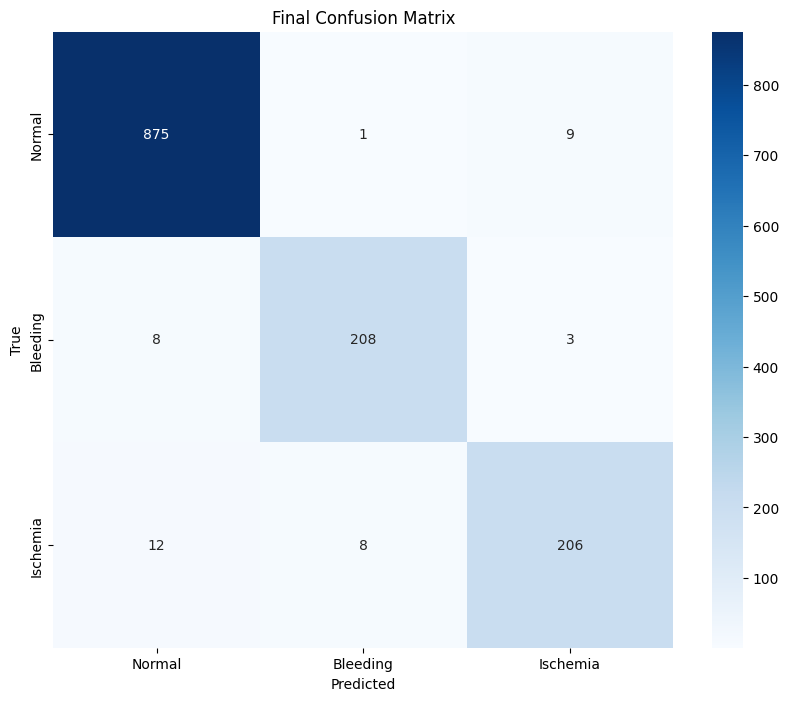

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_brain_ct_model.pth"))

# Final evaluation
_, final_acc, final_preds, final_targets = validate(model, val_loader, criterion, device)
print(f"\nFinal Validation Accuracy: {final_acc:.4f}")

# Print detailed classification report
print("\nFinal Classification Report:")
print(classification_report(final_targets, final_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix')
plt.show()

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_samples=10):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_images.extend(inputs.cpu())
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            if len(all_images) >= num_samples:
                break

    # Limit to requested number of samples
    all_images = all_images[:num_samples]
    all_labels = all_labels[:num_samples]
    all_preds = all_preds[:num_samples]

    # Visualize
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, (img, label, pred) in enumerate(zip(all_images, all_labels, all_preds)):
        if i >= len(axes):
            break

        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display
        axes[i].imshow(img)
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, class_names)

In [ ]:
# Testing on External Test Set
external_test_path = os.path.join(dataset_path, "External_Test", "PNG")
if os.path.exists(external_test_path):
    print("\nEvaluating model on external test set...")

    test_images = glob.glob(os.path.join(external_test_path, "*.png"))
    print(f"Found {len(test_images)} images in external test set")

    class ImageOnlyDataset(Dataset):
        def __init__(self, image_paths, transform=None):
            self.image_paths = image_paths
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)
            else:
                image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

            return image, os.path.basename(img_path)  # Return image and filename

    test_dataset = ImageOnlyDataset(test_images, transform=transform_val)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Get predictions for all images
    model.eval()
    all_filenames = []
    all_predictions = []
    all_raw_outputs = []

    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            # Store results
            all_filenames.extend(filenames)
            all_predictions.extend(preds.cpu().numpy())
            all_raw_outputs.extend(outputs.cpu().numpy())

    # Create a dictionary of predictions
    prediction_dict = {filename: pred for filename, pred in zip(all_filenames, all_predictions)}

    labels_path = os.path.join(dataset_path, "External_Test", "labels.csv")
    if os.path.exists(labels_path):
        with open(labels_path, 'r') as f:
            csv_content = f.read()
            print("CSV file content preview:")
            print(csv_content[:200] + "..." if len(csv_content) > 200 else csv_content)

        labels_df = pd.read_csv(labels_path)
        print("CSV columns:", labels_df.columns.tolist())
        print("First few rows:")
        print(labels_df.head())


        if ',' in str(labels_df.iloc[0, 0]):

            labels_df['image_id'] = labels_df.iloc[:, 0].str.split(',').str[0]
            labels_df['label'] = labels_df.iloc[:, 0].str.split(',').str[1].astype(float).astype(int)
        else:

            labels_df['image_id'] = labels_df.iloc[:, 0]
            labels_df['label'] = labels_df.iloc[:, 1]

        # Match predictions with ground truth
        matched_files = []
        true_labels = []
        pred_labels = []

        for idx, row in labels_df.iterrows():
            image_id = str(row['image_id'])
            true_label = int(row['label'])

            # Find corresponding image file
            matched_file = None

            # Try exact match first
            exact_matches = [f for f in all_filenames if image_id in f]
            if exact_matches:
                matched_file = exact_matches[0]

            if matched_file:
                matched_files.append(matched_file)
                true_labels.append(true_label)
                pred_labels.append(prediction_dict[matched_file])

        print(f"Matched {len(matched_files)} images with labels")

        if len(matched_files) > 0:
            # Convert labels for evaluation (0=Normal, 1=Abnormal)
            # Our model predicts 0=Normal, 1=Bleeding, 2=Ischemia
            # Map 1 and 2 to "Abnormal" (1) for binary evaluation
            binary_preds = [0 if p == 0 else 1 for p in pred_labels]

            # Calculate metrics
            accuracy = accuracy_score(true_labels, binary_preds)
            binary_class_names = ['Normal', 'Abnormal']

            print(f"\nExternal Test Accuracy: {accuracy:.4f}")
            print("\nExternal Test Classification Report:")
            print(classification_report(true_labels, binary_preds, target_names=binary_class_names))

            # Plot confusion matrix
            cm = confusion_matrix(true_labels, binary_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=binary_class_names, yticklabels=binary_class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('External Test Confusion Matrix')
            plt.show()

            # Visualize some examples
            vis_indices = np.random.choice(len(matched_files), min(10, len(matched_files)), replace=False)

            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            axes = axes.flatten()

            for i, idx in enumerate(vis_indices):
                if i >= len(axes):
                    break

                # Load and display image
                img_path = os.path.join(external_test_path, matched_files[idx])
                img = Image.open(img_path).convert('RGB')

                # Display
                axes[i].imshow(img)
                true_label = true_labels[idx]
                pred_label = binary_preds[idx]
                color = 'green' if true_label == pred_label else 'red'
                axes[i].set_title(f"True: {binary_class_names[true_label]}\nPred: {binary_class_names[pred_label]}", color=color)
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

            # List incorrect predictions
            incorrect_indices = [i for i, (t, p) in enumerate(zip(true_labels, binary_preds)) if t != p]
            if incorrect_indices:
                print("\nIncorrect Predictions:")
                for i in incorrect_indices[:min(10, len(incorrect_indices))]:
                    print(f"File: {matched_files[i]}, True: {binary_class_names[true_labels[i]]}, Pred: {binary_class_names[binary_preds[i]]}")
            else:
                print("\nAll predictions are correct!")
        else:
            print("No matches found between images and labels")
    else:
        print("External test set found but no labels.csv file")
else:
    print("External test set not found")